#  <font color='#FFE15D'><b>💎 Project 1: Language Modeling 🎼</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 **Environment Setup**

## 🟠 The command for connecting Colab to the local host (PC or laptop) is as follows:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.0 MB/s eta 0:00:00


## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 Install `portalocker`

In [ ]:
!pip install -q portalocker>=2.0.0

# 🔴 **Import Libs**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.0.1+cu118
torchtext --> 0.15.2+cpu
tqdm --> 4.66.1


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 Load the Dataset

🔰 In this session you should load WikiText2 dataset.

In [ ]:
train_iter, valid_iter, test_iter = WikiText2('/content/')

In [ ]:
train_iter

ShardingFilterIterDataPipe

In [ ]:
class CustomDataset(torch.utils.data.IterableDataset):

  def __init__(self):
    pass

  def __iter__(self):
    pass

In [3]:
train_iter_ = iter(train_iter)
train_iter_

NameError: name 'train_iter' is not defined

In [2]:
next(train_iter_)

NameError: name 'train_iter_' is not defined

## 🟠 Build vocabulary and save it

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
txt = ['@sajad hi sajad! 1 n2 3 #45', 'how are are you?']
tokenizer = get_tokenizer('basic_english')
[tokenizer(line) for line in txt]
list(map(tokenizer, txt))

In [1]:
vocab = build_vocab_from_iterator(map(tokenizer, txt), specials=['<ukn>'], min_freq=2)
vocab.set_default_index(vocab['<ukn>'])
vocab.get_stoi()

NameError: name 'build_vocab_from_iterator' is not defined

In [ ]:
vocab(['hi', 'sajad', '<ukn>', 'hello', 'Hi'.lower()])

[8, 11, 0, 0, 8]

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab(['sajad', 'hi', 'how'])

[0, 9206, 416]

In [ ]:
len(vocab)

28782

In [ ]:
vocab.get_stoi()

In [ ]:
torch.save(vocab, 'vocab.pt')

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [ ]:
total_sentence_count = 0
total_sentence_length = 0

for line in train_iter:
    sentences = line.split('.')

    for sentence in sentences:
        tokens = sentence.strip().split()
        sentence_length = len(tokens)

        if sentence_length > 0:
            total_sentence_count += 1
            total_sentence_length += sentence_length

mean_sentence_length = total_sentence_length / total_sentence_count

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


### 🟡 Analyze the most common and least common words in the dataset.

In [ ]:
freqs = Counter([1, 2, 2, 3, 2, 3])
freqs

Counter({1: 1, 2: 3, 3: 2})

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [ ]:
freqs.most_common()[-6000:]

### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in train_iter])

seq_len = 120
M = len(data) // seq_len

r = len(data) % seq_len
data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

inputs = data[:M*seq_len]
inputs = inputs.reshape(-1, seq_len)

targets = data[1:M*seq_len+1]
targets = targets.reshape(-1, seq_len)

inputs.shape, targets.shape

(torch.Size([17083, 120]), torch.Size([17083, 120]))

In [ ]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [ ]:
del data, inputs, targets

In [ ]:
inputs, targets = data_process(train_iter, seq_len=65)
inputs.shape, targets.shape

(torch.Size([31538, 65]), torch.Size([31538, 65]))

In [ ]:
seq_len = 35

X_train, y_train = data_process(train_iter, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                        dropout=dropout_rnn, batch_first=True)

    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
model(x_batch).shape

torch.Size([20, 35, 28782])

In [ ]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(8.6346, 3.76832, 14.765166)

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim,
                      hidden_dim, num_layers,
                      dropout_embd, dropout_rnn).to(device)

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

metric = tm.text.Perplexity().to(device)

In [ ]:
clip = 0.25

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(10.2649, device='cuda:0')


In [ ]:
outputs.reshape(-1, outputs.shape[-1]).shape, targets.flatten().shape

(torch.Size([700, 28782]), torch.Size([700]))

In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 51.24batch/s, loss=0.246, metric=1.28]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 1

for lr in [2, 0.9, 0.5, 0.3, 0.09, 0.05]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)
  model = torch.load('/content/model-ppl_147.pt')

  # optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=2


100%|██████████| 2929/2929 [00:51<00:00, 56.90batch/s, loss=4.42, metric=83]



LR=0.9


100%|██████████| 2929/2929 [00:52<00:00, 56.01batch/s, loss=4.31, metric=74.2]



LR=0.5


100%|██████████| 2929/2929 [00:51<00:00, 56.99batch/s, loss=4.29, metric=72.6]



LR=0.3


100%|██████████| 2929/2929 [00:50<00:00, 57.70batch/s, loss=4.29, metric=72.6]



LR=0.09


 93%|█████████▎| 2716/2929 [00:46<00:03, 57.85batch/s, loss=4.32, metric=75.2]


KeyboardInterrupt: ignored

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 1

for lr in [3.]:
  for wd in [1e-6, 1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=3.0, WD=1e-06


100%|██████████| 2929/2929 [00:51<00:00, 57.41batch/s, loss=5.88, metric=360]



LR=3.0, WD=0.0001


100%|██████████| 2929/2929 [00:51<00:00, 57.07batch/s, loss=6.25, metric=520]



LR=3.0, WD=1e-05


100%|██████████| 2929/2929 [00:50<00:00, 57.60batch/s, loss=5.92, metric=373]

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.5).to(device)

In [ ]:
model = torch.load('/content/model-ppl_133.pt')

In [ ]:
lr = 0.05
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [00:58<00:00, 50.01batch/s, loss=4.02, metric=55.7]


Model Saved!
Valid: Loss = 4.885, Metric = 132.3



Epoch 2: 100%|██████████| 2929/2929 [00:58<00:00, 50.19batch/s, loss=4.01, metric=55.1]


Model Saved!
Valid: Loss = 4.885, Metric = 132.3



Epoch 3: 100%|██████████| 2929/2929 [00:57<00:00, 50.79batch/s, loss=4, metric=54.7]


Valid: Loss = 4.887, Metric = 132.5



Epoch 4: 100%|██████████| 2929/2929 [00:57<00:00, 50.73batch/s, loss=4, metric=54.4]


Valid: Loss = 4.888, Metric = 132.7



Epoch 5: 100%|█████████▉| 2927/2929 [00:57<00:00, 50.73batch/s, loss=3.99, metric=54.1]


KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🟠 Main Loop

🔰 Define model.

In [ ]:
model =

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

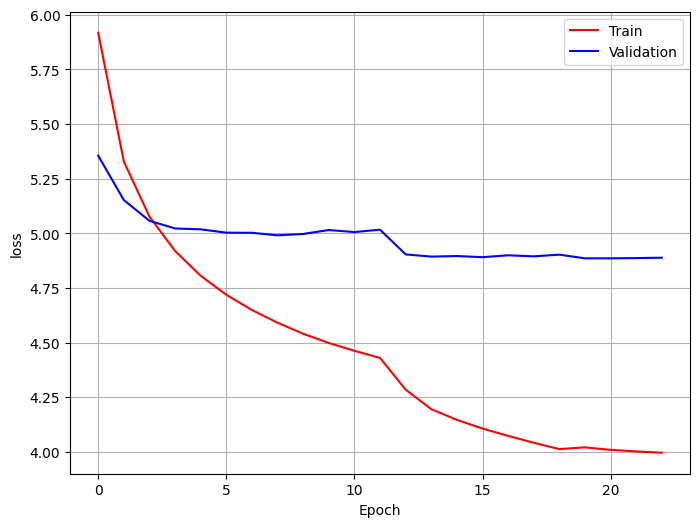

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)